In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import seaborn as sns
import random
import pathlib

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [ ]:
base_dir = '/content/drive/MyDrive/trash_dataset'
dataset = pathlib.Path(base_dir)
print(str(dataset))

/content/drive/MyDrive/trash_dataset


In [ ]:
train_dir = str(dataset) + '/train'
test_dir = str(dataset) + '/test'
data_train = pathlib.Path(train_dir)
data_test = pathlib.Path(test_dir)

print(str(data_train))
print(str(data_test))

/content/drive/MyDrive/trash_dataset/train
/content/drive/MyDrive/trash_dataset/test


In [ ]:
class_names = np.array(tf.io.gfile.listdir(str(data_train)))
class_names = class_names[class_names != '.DS_Store']
print(class_names)

['paper' 'metal' 'plastic' 'glass' 'trash' 'cardboard']


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 6 classes.
Using 2160 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 6 classes.
Using 540 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)


In [ ]:
def get_image(file_path):
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [img_height, img_width])
  return img

In [ ]:
def get_img_and_label(file_path):
  label = get_label(file_path)
  img = get_image(file_path)
  return img, label

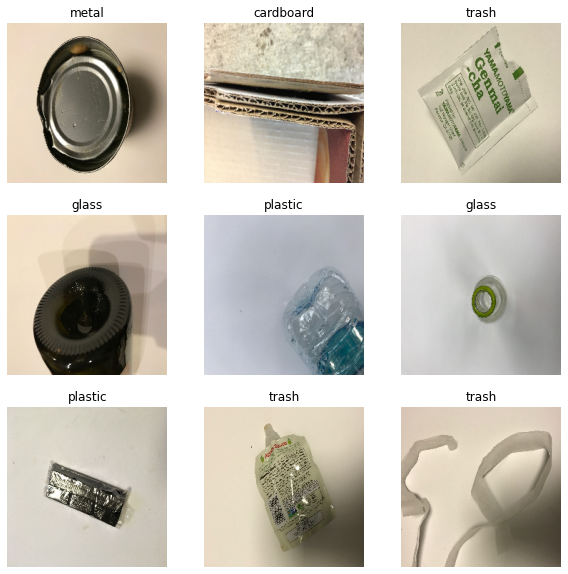

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1)
  ]
)

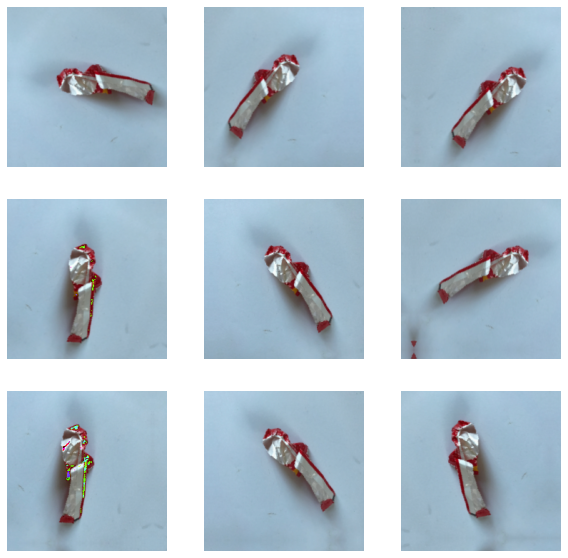

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def pre_process(image_files):
  files_ds = tf.data.Dataset.from_tensor_slices(image_files)
  image_ds = files_ds.map(map_func=get_img_and_label, num_parallel_calls=AUTOTUNE)
  return image_ds

In [ ]:
num_classes = len(class_names)
print(num_classes)

6


In [ ]:
with strategy.scope():
  inputs = layers.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = layers.Rescaling(scale=1./127.5, offset=-1)(x)
  
  x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(64, activation='relu')(x)
  output = layers.Dense(num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs, output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 32)      0         
                                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
epochs = 100

hist = model.fit(train_ds, 
                 epochs=epochs, 
                 validation_data=val_ds)
                 #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=50))

Epoch 1/100
68/68 [==============================] - 43s 585ms/step - loss: 1.6797 - accuracy: 0.2667 - val_loss: 1.5040 - val_accuracy: 0.4407
Epoch 2/100
68/68 [==============================] - 12s 174ms/step - loss: 1.4312 - accuracy: 0.4380 - val_loss: 1.3299 - val_accuracy: 0.4852
Epoch 3/100
68/68 [==============================] - 12s 173ms/step - loss: 1.2714 - accuracy: 0.5065 - val_loss: 1.2261 - val_accuracy: 0.5370
Epoch 4/100
68/68 [==============================] - 12s 172ms/step - loss: 1.2061 - accuracy: 0.5296 - val_loss: 1.1599 - val_accuracy: 0.5630
Epoch 5/100
68/68 [==============================] - 12s 172ms/step - loss: 1.1418 - accuracy: 0.5620 - val_loss: 1.1245 - val_accuracy: 0.5852
Epoch 6/100
68/68 [==============================] - 12s 175ms/step - loss: 1.1444 - accuracy: 0.5593 - val_loss: 1.0220 - val_accuracy: 0.6407
Epoch 7/100
68/68 [==============================] - 12s 172ms/step - loss: 1.0603 - accuracy: 0.6102 - val_loss: 0.9614 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/My_Model_0.85.h5')

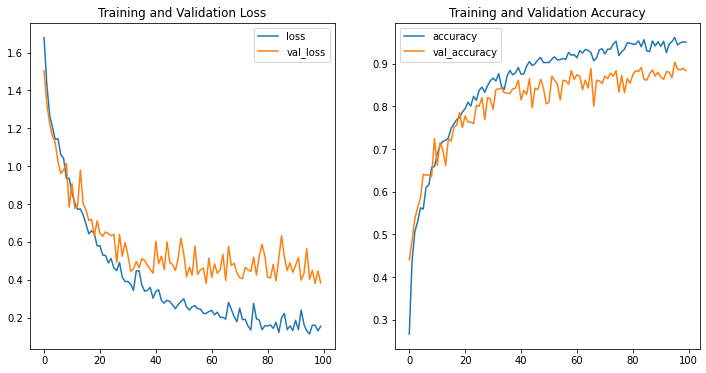

In [ ]:
metrics = hist.history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(hist.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
test_files = filenames = tf.io.gfile.glob(str(data_test) + '/*/*.jpg')
test_ds = pre_process(test_files)
print(len(test_files))

630


In [ ]:
test_images = []
test_labels = []

for image, label in test_ds:
  test_images.append(image.numpy())
  test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = test_labels

In [ ]:
loss, acc = model.evaluate(test_images, test_labels)
print('Restored model, accuracy: {:5.0f}%'.format(100 * acc))

20/20 [==============================] - 2s 55ms/step - loss: 0.6369 - accuracy: 0.8460
Restored model, accuracy:    85%


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   cardboard       0.94      0.83      0.88       101
       glass       0.80      0.85      0.82       125
       metal       0.80      0.80      0.80       102
       paper       0.91      0.91      0.91       148
     plastic       0.83      0.85      0.84       120
       trash       0.71      0.71      0.71        34

    accuracy                           0.85       630
   macro avg       0.83      0.83      0.83       630
weighted avg       0.85      0.85      0.85       630



In [ ]:
import sklearn.metrics as skm

cm = skm.multilabel_confusion_matrix(y_true, y_pred)
print(cm)

[[[524   5]
  [ 17  84]]

 [[479  26]
  [ 19 106]]

 [[507  21]
  [ 20  82]]

 [[468  14]
  [ 13 135]]

 [[489  21]
  [ 18 102]]

 [[586  10]
  [ 10  24]]]


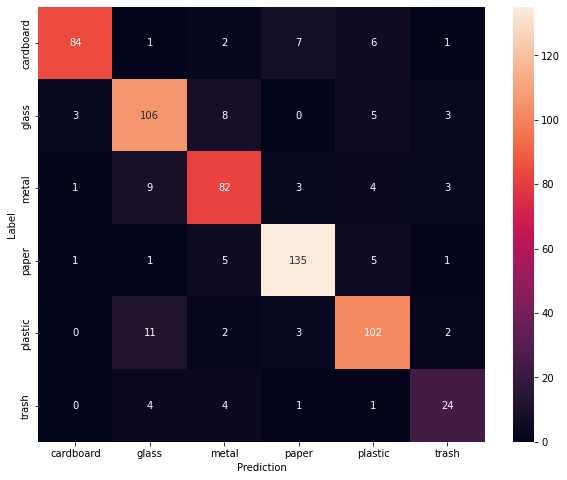

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()